In [1]:
using Pkg

Pkg.activate("Agate")

  Activating project at `~/Documents/Projects/Agate.jl`


In [2]:
using Agate

using DifferentialEquations
using Oceananigans
using OceanBioME
using Plots

using Oceananigans.Fields: FunctionField
using Oceananigans.Units


In [3]:
const year = years = 365day

N = 7.0; P = 0.01; Z = 0.05; D=0.0

0.0

## Agate wrapper

In [4]:
timeseries = run_npzd_boxmodel([7.0, 0.01, 0.05, 0.0])
nothing

[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (762.337 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (284.552 ms).
[ Info: Simulation is stopping after running for 12.696 seconds.
[ Info: Simulation time 1095 days equals or exceeds stop time 1095 days.


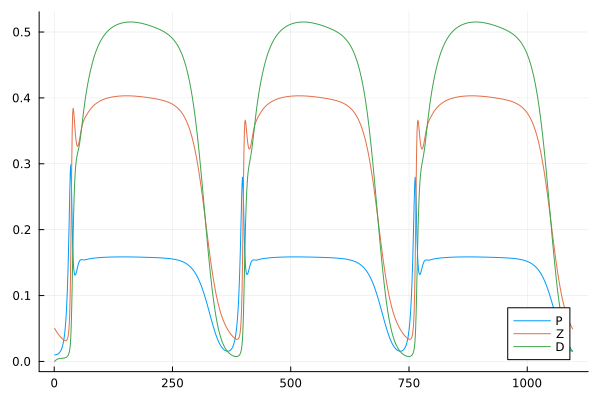

In [5]:
p = plot(timeseries.P, label="P")
plot!(p, timeseries.Z, label="Z")
plot!(p, timeseries.D, label="D")

## OceanBioME

Manually time stepping through the sim

In [6]:
PAR⁰(t) = 60 * (1 - cos((t + 15days) * 2π / year)) * (1 / (1 + 0.2 * exp(-((mod(t, year) - 200days) / 50days)^2))) + 2

const z = -10 # specify the nominal depth of the box for the PAR profile
PAR_f(t) = PAR⁰(t) * exp(0.2z) # Modify the PAR based on the nominal depth and exponential decay

PAR_f (generic function with 1 method)

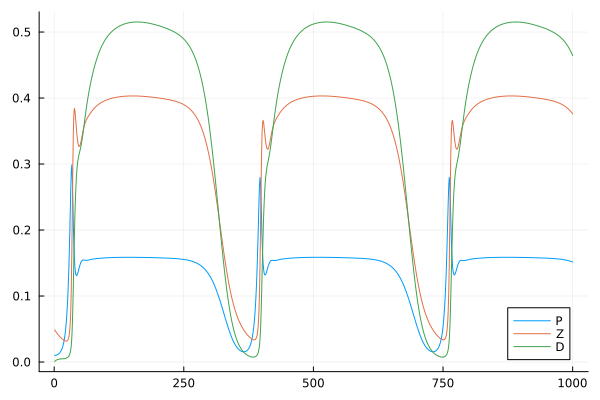

In [7]:
grid = BoxModelGrid()
clock = Clock(time = zero(grid))

PAR = FunctionField{Center, Center, Center}(PAR_f, grid; clock)

biogeochemistry = NutrientPhytoplanktonZooplanktonDetritus(; 
    grid, 
    light_attenuation_model = PrescribedPhotosyntheticallyActiveRadiation(PAR),
    sinking_speeds = NamedTuple()
)
model = BoxModel(;biogeochemistry, clock)

set!(model, N=N, P=P, Z=Z, D=D)

vals_d = []
vals_z = []
vals_p = []
for i in range(1,1000)
    time_step!(model, 1day)
    push!(vals_d, model.fields.D.data[1,1,1])
    push!(vals_z, model.fields.Z.data[1,1,1])
    push!(vals_p, model.fields.P.data[1,1,1])
end

p = plot(vals_p, label="P")
plot!(p, vals_z, label="Z")
plot!(p, vals_d, label="D")

## DifferentialEquations

The handling of time is a bit different so we simplify the PAR function for now to get around this.

In [8]:
PAR⁰_simple(t) = 60 * (1 - cos(2π * t / 365)) + 2 
PAR_f_simple(t) = PAR⁰_simple(t) * exp(0.2z)

PAR_f_simple (generic function with 1 method)

In [9]:
# NPZD equations here

nutrient_limitation(N, kₙ) = N / (kₙ + N)

light_limitation(PAR, α, μ₀)= α * PAR / sqrt(μ₀ ^ 2 + α ^ 2 * PAR ^ 2)

phytoplankton_metabolic_loss(P, lᵖⁿ) = lᵖⁿ  * P 

zooplankton_metabolic_loss(Z, lᶻⁿ) = lᶻⁿ  * Z 

remineralization(D, rᵈⁿ) = rᵈⁿ * D

phytoplankton_growth(N, P, PAR, μ₀, kₙ, α) = μ₀ * nutrient_limitation(N, kₙ) * light_limitation(PAR, α, μ₀) * P
phytoplankton_grazing_loss(P, Z, gₘₐₓ, kₚ) = gₘₐₓ * nutrient_limitation(P ^ 2, kₚ ^ 2) * Z
phytoplankton_mortality_loss(P, lᵖᵈ) = lᵖᵈ * P

zooplankton_grazing_gain(P, Z, β, gₘₐₓ, kₚ) = β * gₘₐₓ * nutrient_limitation(P ^ 2, kₚ ^ 2) * Z
zooplankton_mortality_loss(Z, lᶻᵈ) = lᶻᵈ * Z ^ 2
zooplankton_assimilation_loss(P, Z, β, gₘₐₓ, kₚ) = (1 - β) * gₘₐₓ * nutrient_limitation(P ^ 2, kₚ ^ 2) * Z


zooplankton_assimilation_loss (generic function with 1 method)

In [10]:
function NPZD(du, u, p, t)

    # Model parameters.
    μ₀, kₙ, lᵖⁿ, lᶻⁿ, lᵖᵈ, gₘₐₓ, kₚ, β, lᶻᵈ, rᵈⁿ, α = p 
    # Current state.
    N, P, Z, D = u

    PAR = PAR_f_simple(t)

    # Evaluate differential equations
    du[1]= phytoplankton_metabolic_loss(P, lᵖⁿ) + zooplankton_metabolic_loss(Z, lᶻⁿ) + remineralization(D, rᵈⁿ) - phytoplankton_growth(N, P, PAR, μ₀, kₙ, α)
    du[2] = phytoplankton_growth(N, P, PAR, μ₀, kₙ, α) - phytoplankton_grazing_loss(P, Z, gₘₐₓ, kₚ) - phytoplankton_metabolic_loss(P, lᵖⁿ) - phytoplankton_mortality_loss(P, lᵖᵈ)
    du[3] = zooplankton_grazing_gain(P, Z, β, gₘₐₓ, kₚ) - zooplankton_metabolic_loss(Z, lᶻⁿ) - zooplankton_mortality_loss(Z, lᶻᵈ)
    du[4] = phytoplankton_mortality_loss(P, lᵖᵈ) + zooplankton_assimilation_loss(P, Z, β, gₘₐₓ, kₚ) + zooplankton_mortality_loss(Z, lᶻᵈ) - remineralization(D, rᵈⁿ)

    return nothing
end

NPZD (generic function with 1 method)

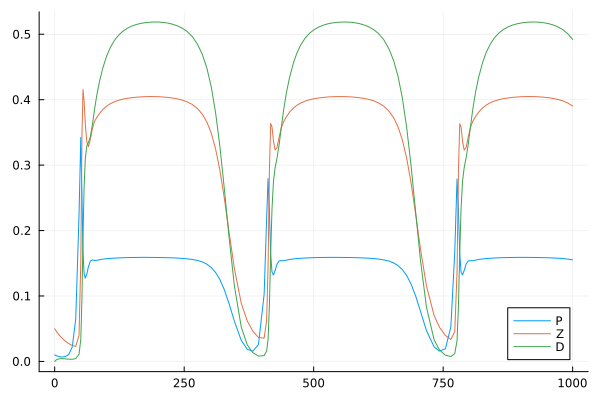

In [11]:
# N,P,Z,D
u0 = [7.0, 0.01, 0.05, 0.0]

p = [0.6989, 2.3868, 0.066, 0.0102, 0.0101, 2.1522, 0.5573, 0.9116, 0.3395, 0.1213, 0.1953]

tspan = (0.0,1000)

prob = ODEProblem(NPZD, u0, tspan, p)

# sol = solve(prob, Tsit5(), dt=0.01, adaptive=false)
sol = solve(prob, Tsit5())

# plot(sol)
p = plot(sol.t, [sol.u[i][2] for i in range(1, length(sol))], label="P")
plot!(p, sol.t, [sol.u[i][3] for i in range(1, length(sol))], label="Z")
plot!(p, sol.t, [sol.u[i][4] for i in range(1, length(sol))], label="D")

The differences we see in the results correspond to the differences between the two PAR functions.

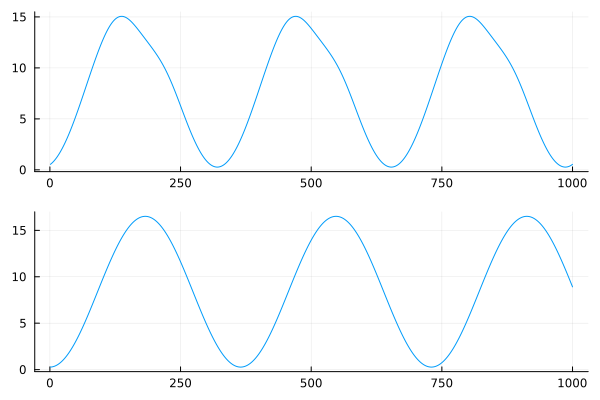

In [12]:
x = range(0, 3years, length=1000)
p1 = plot(PAR_f.(x))

x = [1:1000;]
p2 = plot(PAR_f_simple.(x))

plot(p1, p2, layout = (2,1), legend = false)